# 1. Pre-reqs
We may need to install the rrscale and memnorm packages

In [1]:
#install.packages('../r_packages/rrscale_rpkg/rrscale_1.0.3.tar.gz', repos=NULL,type="source")
#install.packages('../r_packages/mema_norm_rpkg/memanorm_0.0.0.9005.tar.gz', repos=NULL,type="source")

In [2]:
library('rrscale')
devtools::load_all('../r_packages/mema_norm_rpkg/memanorm/')
source('processing_scripts/util.R')

ℹ Loading memanorm



# and then we'll set up a directory for the processed data

In [3]:
# identifying tag for the data
tag = "MCF10A"

# directory to put processed data
ddir ='processed_data/'%+%tag%+%"/"
dir.create(ddir,showWarning=FALSE,recursive=TRUE)

In [4]:
# Now let's make a list containing the feature matrices 
source('processing_scripts/make_data_matrices.R') # helper script
tsv_dir = 'raw_data/'%+%tag%+%'/'
data = make_data_matrices(tsv_dir)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last




here each feature matrix is has a row for each well and a column for each spot. We can look at the dimension of the first few feature matrices

we'll make the list of features we want to RR transform

In [5]:
to_rr = grep("_PA_|_CP_",names(data),value=TRUE)
to_rr = to_rr[!grepl("_SE",to_rr)]
unum = sapply(to_rr,function(x)length(unique(unlist(data[[x]]))))
to_rr = names(unum[unum>20])
sample(to_rr,5)

[1] "Nuclei_CP_AreaShape_MaximumRadius"                     
[2] "Cells_CP_AreaShape_MaximumRadius"                      
[3] "Nuclei_CP_Texture_AngularSecondMoment_Fibrillarin_3_90"
[4] "Cytoplasm_CP_Intensity_MedianIntensity_KRT19"          
[5] "Cytoplasm_PA_Gated_KRT5PositiveProportion"

and then save the feature matrices and list of features

In [6]:
dl = list(data=data,rr_feats = to_rr)

In [7]:
fn = ddir%+%tag%+%'.rds'
fn

[1] "processed_data/MCF10A/MCF10A.rds"

In [8]:
if(!file.exists(fn))
    saveRDS(dl,fn)

now we can apply the RR transformation to the matrices (this can take a while)

# 2. RRScale

In [9]:
source('processing_scripts/estimate.R',chdir=TRUE)
scaledY_file = ddir%+%"scaledY_"%+%tag%+%".rds"
if(file.exists(scaledY_file)){
    cat("Reading from cache.\n")
    scaledY = readRDS(scaledY_file)
} else {
    cat("No cache, re-running.\n")
    scaledY = scale_data(dl)
    saveRDS(scaledY,file=scaledY_file)
}

Reading from cache.


# 3. Clean up spatial effects

In [10]:
base_fmats = dl$data
rr_fmats_unproc = lapply(scaledY,"[[","RR")

ecmps = factor(unlist(base_fmats$ECMp[1,]))
ligands = factor(unlist(base_fmats$Ligand[,1]))

find which features are measured in all batches for normalization (the "dapi" features)

In [11]:
rr_fmats_im = lapplyp(rr_fmats_unproc, memanorm::row_impute_fn, ecmps, verbose = TRUE, .name = "Imputing")


Imputing [>-------------------------------------------------------------------------] 2/116 (  2%) elapsed:  2s eta:  2m

Imputing [=>------------------------------------------------------------------------] 3/116 (  3%) elapsed:  3s eta:  2m

Imputing [==>-----------------------------------------------------------------------] 4/116 (  3%) elapsed:  4s eta:  2m

Imputing [==>-----------------------------------------------------------------------] 5/116 (  4%) elapsed:  6s eta:  2m

Imputing [===>----------------------------------------------------------------------] 6/116 (  5%) elapsed:  7s eta:  2m

Imputing [===>----------------------------------------------------------------------] 7/116 (  6%) elapsed:  8s eta:  2m

Imputing [====>---------------------------------------------------------------------] 8/116 (  7%) elapsed: 10s eta:  2m

Imputing [=====>--------------------------------------------------------------------] 9/116 (  8%) elapsed: 11s eta:  2m

Imputing [=====>-------

In [12]:
rr_fmats = rr_fmats_im

In [13]:
all_batches = names(rr_fmats)

In [14]:
d_none = 0
unadj_norm_out = remove_spatial(f_mats = rr_fmats,
                  adj_idx = all_batches,
                  row_rep = ligands,
                  col_rep = ecmps,
                  d=d_none,
                  verbose=FALSE,
                  row_center=FALSE,
                  row_impute=FALSE)
unadj_fmats=unadj_norm_out$f_adj
names(unadj_fmats) <- names(unadj_fmats)%+%"_RR"

In [15]:
unadj_fmats0 = rr_fmats_unproc
names(unadj_fmats0) <- names(unadj_fmats0)%+%"_RR"

In [16]:
adj_fmat_l = list()

In [17]:
d_adj_list = c(0,1,2,3,5,7,10,15,25)
for(d_adj in d_adj_list){
    cat(paste0("Adjusting for spatial effects d=",d_adj,"\n"))
    flush.console()
    norm_out = remove_spatial(f_mats = rr_fmats,
                      adj_idx = all_batches,
                      row_rep = ligands,
                      col_rep = ecmps,
                      d=d_adj,
                      verbose=FALSE,
                      full.results=TRUE,
                      row_center=FALSE,
                      row_impute=FALSE)
    adj_fmats=norm_out$f_adj
    names(adj_fmats) <- names(adj_fmats)%+%"_RR_ADJ"
    adj_fmats_spatial = adj_fmats
    
    adj_fmat_l[[length(adj_fmat_l)+1]] = adj_fmats
}


Adjusting for spatial effects d=0
Adjusting for spatial effects d=1
Adjusting for spatial effects d=2
Adjusting for spatial effects d=3
Adjusting for spatial effects d=5
Adjusting for spatial effects d=7
Adjusting for spatial effects d=10
Adjusting for spatial effects d=15
Adjusting for spatial effects d=25


# plot $\hat{S}$

In [18]:
library('ggplot2')


Attaching package: ‘ggplot2’


The following object is masked _by_ ‘.GlobalEnv’:

    %+%


The following object is masked from ‘package:memanorm’:

    %+%




In [19]:
norm_out = remove_spatial(f_mats = rr_fmats,
                      adj_idx = all_batches,
                      row_rep = ligands,
                      col_rep = ecmps,
                      d=15,
                      verbose=FALSE,
                      row_impute=FALSE,
                      full.results=TRUE)

In [20]:
k=15

[1] 667  15

Warning message in melt(sh, id.vars = c("rw", "cl")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(sh). In the next version, this warning will become an error.”


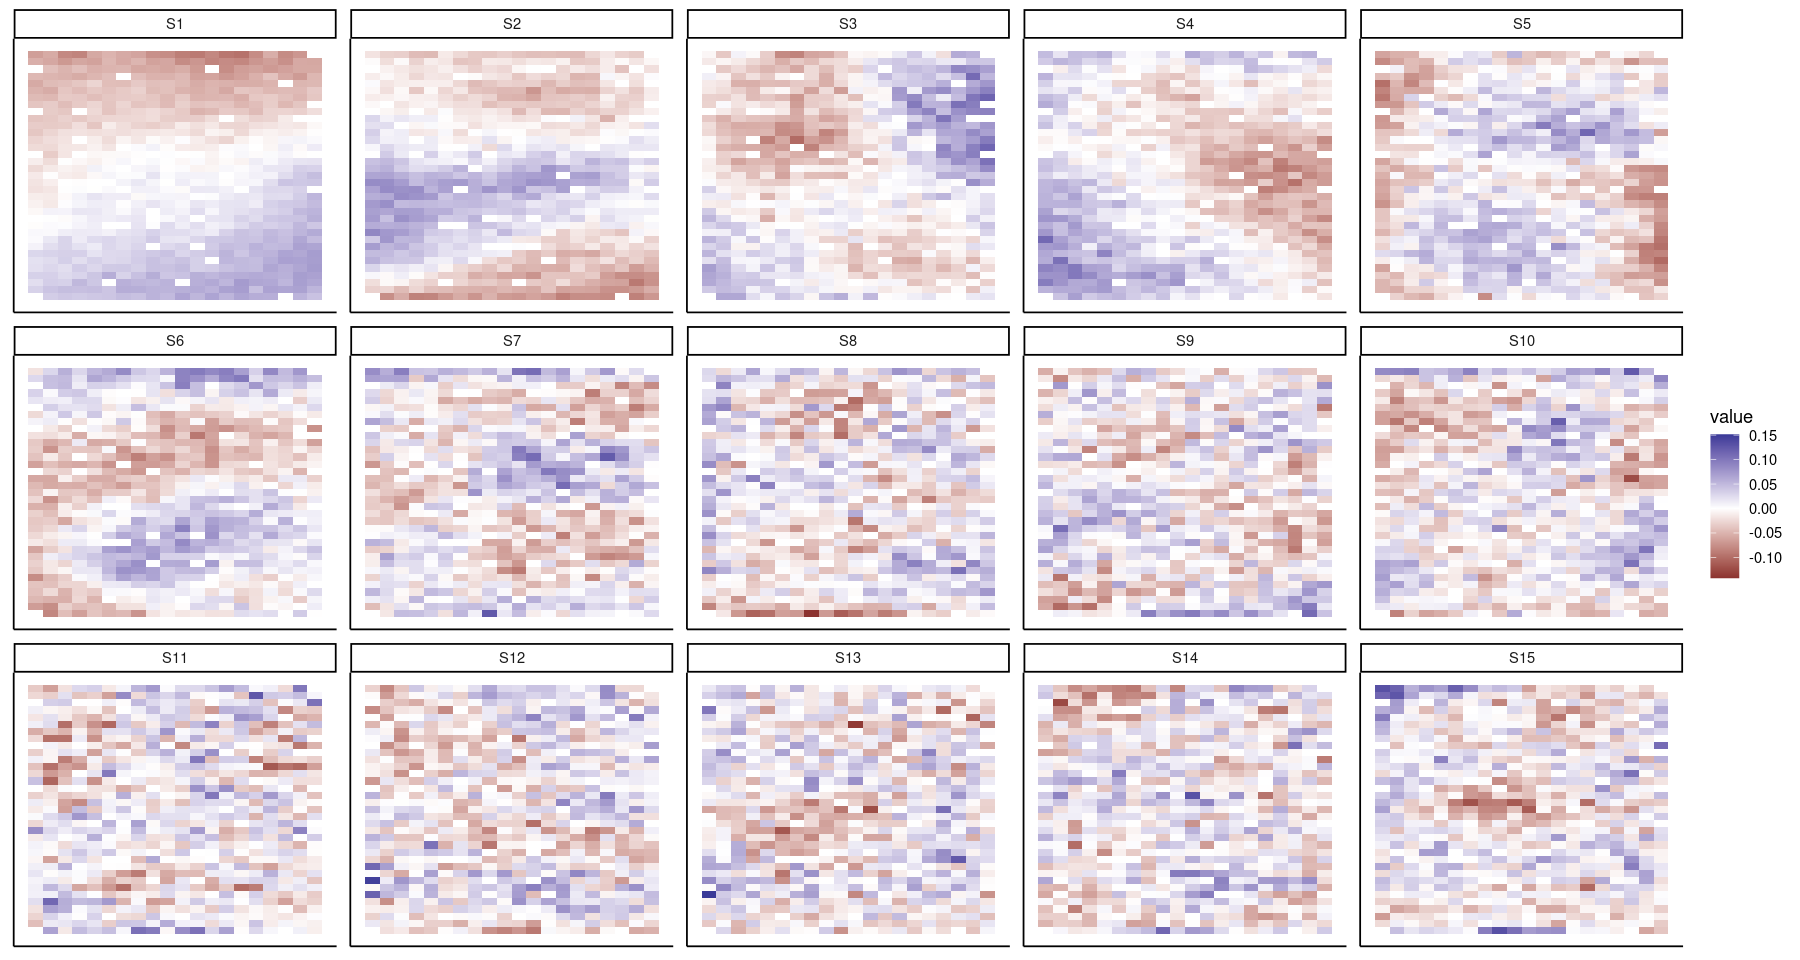

In [21]:
sh = norm_out$s_hat[1:k,,drop=FALSE]
sh = data.frame(t(sh))
colnames(sh) = paste0("S",1:k)
dim(sh)
rw = base_fmats[['PrintRow']]
cl = base_fmats[['PrintColumn']]
sh$rw = rw[1,]
sh$cl = cl[1,]
msh = melt(sh,id.vars=c('rw','cl'))
options(repr.plot.width = 15, repr.plot.height = 8)
plt = ggplot(data=msh,mapping=aes(x=cl,y=rw,fill=value))+
    facet_wrap(~variable,nrow=3,scale='free')+
    geom_tile()+
    theme_classic()+
    scale_fill_gradient2()+
    theme(axis.title.x=element_blank(),
              axis.text.x=element_blank(),
              axis.ticks.x=element_blank())+
            theme(axis.title.y=element_blank(),
              axis.text.y=element_blank(),
              axis.ticks.y=element_blank())
plt
ggsave(plot=plt,file="S.pdf",width=5,height=5)

# 4. make .csv data matrices

In [22]:
library('data.table')

In [23]:
to_csv = function(adj_fmats,d_adj,tg=''){
    cat(d_adj,"\n")
    flush.console()
    dmsn = dim(base_fmats[[1]])
    fmat_col = array(rep(1:dmsn[2],each=dmsn[1]),dmsn)
    fmat_row = t(array(rep(1:dmsn[1],each=dmsn[2]),rev(dmsn)))
    fmat_dims = list("fcol"=fmat_col,"frow"=fmat_row)
    
    all_fmats = c(base_fmats,unadj_fmats,adj_fmats,fmat_dims)
    all_fmats = lapply(all_fmats,data.table)
    
    ul_all_fmats = lapply(all_fmats,unlist)
    d = data.frame(ul_all_fmats)
    
    dir.create(ddir%+%"csv/",showWarnings=FALSE,recursive=TRUE)
    write.csv(x=d,file=ddir%+%"csv/"%+%tag%+%"_"%+%d_adj%+%"_df"%+%tg%+%".csv")
    write.csv(names(adj_fmats),file=ddir%+%"csv/"%+%tag%+%"_"%+%d_adj%+%"_features"%+%tg%+%".csv")
    return(d)
}

In [24]:
stopifnot(length(d_adj_list)==length(adj_fmat_l))

In [25]:
toss = lapply(1:length(d_adj_list),function(i)to_csv(adj_fmat_l[[i]],d_adj_list[[i]],tg=''))

0 
1 
2 
3 
5 
7 
10 
15 
25 
